In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys

sys.path.append('/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week')

In [18]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

from datasets import load_dataset
from phd_qwen import get_phd_single, get_phd_single_loop, get_embeds, get_raw_phd
from GPTID.IntrinsicDim import PHD
from transformers import AutoTokenizer, AutoModel

В качестве художественных текстов будем использовать [lucadiliello/bookcorpusopen](https://huggingface.co/datasets/lucadiliello/bookcorpusopen). У данного датасета изначально был прорадитель `bookcorpus`, но его удалили из-за авторского права.

Для научных текстов используем [ccdv/arxiv-summarization](https://huggingface.co/datasets/ccdv/arxiv-summarization). Набор научных статей по различным темам.

In [5]:
from datasets import load_dataset

# Фикшн истории (художестенные)
bookcorpus = load_dataset("lucadiliello/bookcorpusopen", split="train")
# arXiv (научные статьи)
arxiv = load_dataset("ccdv/arxiv-summarization", split="train")

README.md:   0%|          | 0.00/400 [00:00<?, ?B/s]

(…)-00000-of-00014-e40347a4a9a752dd.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

(…)-00001-of-00014-4f769efe80e66fc3.parquet:   0%|          | 0.00/276M [00:00<?, ?B/s]

(…)-00002-of-00014-fb4feb3c719446aa.parquet:   0%|          | 0.00/285M [00:00<?, ?B/s]

(…)-00003-of-00014-02d44dfa3e71d7db.parquet:   0%|          | 0.00/279M [00:00<?, ?B/s]

(…)-00004-of-00014-f13bdb35926815eb.parquet:   0%|          | 0.00/284M [00:00<?, ?B/s]

(…)-00005-of-00014-4306e38807aec8ea.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

(…)-00006-of-00014-d6a12d722a46f987.parquet:   0%|          | 0.00/272M [00:00<?, ?B/s]

(…)-00007-of-00014-9ca5d4d4fb468d96.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

(…)-00008-of-00014-e6e5e9598b224507.parquet:   0%|          | 0.00/283M [00:00<?, ?B/s]

(…)-00009-of-00014-a8ecf1b869b5fa7c.parquet:   0%|          | 0.00/268M [00:00<?, ?B/s]

(…)-00010-of-00014-7dfefa88147121dc.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

(…)-00011-of-00014-19c764033d9839eb.parquet:   0%|          | 0.00/288M [00:00<?, ?B/s]

(…)-00012-of-00014-8d37c841e68119d0.parquet:   0%|          | 0.00/271M [00:00<?, ?B/s]

(…)-00013-of-00014-523aa82c71ab4ceb.parquet:   0%|          | 0.00/268M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17868 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

In [ ]:
print(bookcorpus)

Dataset({
    features: ['text', 'title'],
    num_rows: 17868
})


In [ ]:
print(bookcorpus[400]['text'][9000:11000])

s that the ladies loved. The few who were on Baxter Colony were constantly flirting with him. And he was always one to flirt back, but in a reserved and coy way.

"We did it, Thomas," I said. "Time to let loose."

I was medium height and weight, with brown eyes. Most would say I was unremarkable, making me your dull, boring, average guy. I liked to think it made me every guy or any guy, not that it was of any benefit.

Thomas gave a nod. "Let loose? I have a shuttle to catch, but what'd you have in mind?"

Next up for me was the cold, cruel world of job hunting. But not before a bit of celebration. We were to drop TC at the spaceport, but I hoped to convince him to come with us to a local bar, at least for a short while. We made our way down a long hall toward the building exit.

"Whoa."

I took a step to the side to avoid colliding with a custodial bot. It came from a side room and passed as it cleaned the floor going behind us. I wondered how something being sophisticated enough to b

In [ ]:
print(arxiv)
print(arxiv['train'][0].keys())
print(arxiv['train'][10]['article'][500:3000])

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 203037
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6436
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6440
    })
})
dict_keys(['article', 'abstract'])
ls , vibrations , or other signals . 
 a typical modeling strategy is to treat each individual as a moving particle whose velocity is influenced by social ( interparticle ) attractive and repulsive forces @xcite . in contrast , the _ exogenous _ forces describe an individual s reaction to the environment , for instance a response to gravity , wind , a chemical source , a light source , a food source , or a predator . 
 the superposition of endogenous and exogenous forces can lead to characteristic swarm shapes ; these equilibrium solutions are the subject of our present study . 
 more specifically , our motivation is rooted in our previous modeling stu

Если присмотреться, то в обоих датасетах предложения записаны с переносом на новую строку, что может мешать токенизатору. С другой сторроны, особенность научных текстов как раз в вынесе формул в отдельную строку, но скорее важна смысловая нагрузка текста, пожтому в дальнейшем уберем перенос строки.

## Идея гипотезы

У двух текстов даже разных жанров может быть схожая внутренняя размерность. Стало интересно посмотреть, что будет происходить с `ID`, если объединять два текста одного жанра и разных жанров. Предполагается, что при объединении художетсвенного и научного текстов может расти `ID`, а при объединении оставать на примерно таком же уровне, как у исходных текстов.

Стоит отметить, что также интересно посмотреть на способ объединения двух текстов:

1. Для двух текстов по отдельности найти эмбеддинги и сконкатенировать (модель не будет пытаться сгладить жанровое различие между текстами и различие в эмбеддингах будет сильнее);

2. Объединить тексты и найти эмбеддинги для нового текста (модель уже будет кодировать информацию исходя из всей смысловой нагрузки текста)

В качестве модели будем использовать `Qwen1.5-1.8B`.

## Влияние длины текста на ID

Сначала посмотрим, как будем меняться `ID`, если увеличить количество токенов текста вдвое. Будем брать единый текст от автора. В рамках одного текста предполагается, что автор не сильно менял своего стиля повестовавания. Сначала посчитаем `ID` на половине текста, а затем на всем тексте.

In [6]:
def cut_and_trim(text, trim_chars=9000):
    """
    Удаляет переносы строк, пробельный мусор и обрезает первые trim_chars символов,
    так как в них содержится описание к тексту.
    Возвращает строку, готовую для подачи в get_phd_single.
    """
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())
    return text[trim_chars:]

In [7]:
solver = PHD(metric='euclidean', n_points=9)

phd_1k_list = []
phd_2k_list = []
phd_diff_list = []
record_ids = []

In [ ]:
for i in tqdm(range(50), desc="Computing PHD"):
    try:
        raw_text = bookcorpus[i]['text']
        trimmed = cut_and_trim(raw_text)

        phd_1k = get_phd_single_loop(trimmed, solver, n_tries=5, max_length=512)
        phd_2k = get_phd_single_loop(trimmed, solver, n_tries=5, max_length=1024)
        diff = phd_2k - phd_1k

        phd_1k_list.append(phd_1k)
        phd_2k_list.append(phd_2k)
        phd_diff_list.append(diff)
        record_ids.append(i)

    except Exception as e:
        print(f"Ошибка на тексте #{i}: {e}")
        continue

Computing PHD:   0%|          | 0/50 [00:00<?, ?it/s]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:   2%|▏         | 1/50 [03:00<2:27:38, 180.79s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:   4%|▍         | 2/50 [05:50<2:19:36, 174.51s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:   6%|▌         | 3/50 [08:44<2:16:13, 173.91s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:   8%|▊         | 4/50 [11:39<2:13:54, 174.66s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  10%|█         | 5/50 [14:33<2:10:34, 174.11s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  12%|█▏        | 6/50 [17:22<2:06:35, 172.61s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  14%|█▍        | 7/50 [20:14<2:03:29, 172.31s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  16%|█▌        | 8/50 [23:07<2:00:53, 172.69s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  18%|█▊        | 9/50 [25:58<1:57:28, 171.92s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  20%|██        | 10/50 [28:47<1:53:59, 171.00s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  22%|██▏       | 11/50 [31:34<1:50:30, 170.01s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  24%|██▍       | 12/50 [34:26<1:47:54, 170.39s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  26%|██▌       | 13/50 [37:11<1:44:02, 168.73s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  28%|██▊       | 14/50 [39:58<1:41:05, 168.48s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  30%|███       | 15/50 [42:45<1:37:51, 167.77s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  32%|███▏      | 16/50 [45:29<1:34:28, 166.73s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  34%|███▍      | 17/50 [48:20<1:32:22, 167.96s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  36%|███▌      | 18/50 [51:07<1:29:25, 167.66s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  38%|███▊      | 19/50 [53:52<1:26:14, 166.92s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  40%|████      | 20/50 [56:36<1:23:04, 166.16s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  42%|████▏     | 21/50 [59:21<1:20:10, 165.87s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  44%|████▍     | 22/50 [1:02:05<1:17:05, 165.21s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  46%|████▌     | 23/50 [1:04:51<1:14:29, 165.52s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  48%|████▊     | 24/50 [1:07:35<1:11:28, 164.93s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  50%|█████     | 25/50 [1:10:20<1:08:47, 165.10s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  52%|█████▏    | 26/50 [1:13:05<1:05:56, 164.87s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  54%|█████▍    | 27/50 [1:15:53<1:03:38, 166.01s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  56%|█████▌    | 28/50 [1:18:39<1:00:50, 165.93s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  58%|█████▊    | 29/50 [1:21:23<57:54, 165.44s/it]  

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  60%|██████    | 30/50 [1:24:08<55:02, 165.11s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  62%|██████▏   | 31/50 [1:27:03<53:15, 168.19s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  64%|██████▍   | 32/50 [1:29:46<49:59, 166.62s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  66%|██████▌   | 33/50 [1:32:38<47:40, 168.29s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  68%|██████▊   | 34/50 [1:35:26<44:47, 167.99s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  70%|███████   | 35/50 [1:38:09<41:41, 166.76s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  72%|███████▏  | 36/50 [1:40:59<39:06, 167.63s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  74%|███████▍  | 37/50 [1:43:49<36:26, 168.19s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  76%|███████▌  | 38/50 [1:46:38<33:42, 168.57s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  78%|███████▊  | 39/50 [1:49:27<30:56, 168.75s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  80%|████████  | 40/50 [1:52:17<28:09, 168.96s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  82%|████████▏ | 41/50 [1:55:05<25:19, 168.79s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  84%|████████▍ | 42/50 [1:57:54<22:31, 168.88s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  86%|████████▌ | 43/50 [2:00:38<19:32, 167.45s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  88%|████████▊ | 44/50 [2:03:26<16:45, 167.62s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  90%|█████████ | 45/50 [2:06:13<13:57, 167.46s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  92%|█████████▏| 46/50 [2:08:58<11:05, 166.45s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  94%|█████████▍| 47/50 [2:11:49<08:23, 167.88s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  96%|█████████▌| 48/50 [2:14:33<05:33, 166.78s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD:  98%|█████████▊| 49/50 [2:17:17<02:46, 166.07s/it]

mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 512 point_jump = 67
input_shape: (512, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


Computing PHD: 100%|██████████| 50/50 [2:20:00<00:00, 168.00s/it]


In [ ]:
df_phd = pd.DataFrame({
    "idx": record_ids,
    "PHD_512": phd_1k_list,
    "PHD_1024": phd_2k_list,
    "PHD_diff": phd_diff_list
})
df_phd.to_csv("phd_differences_fiction.csv", index=False)

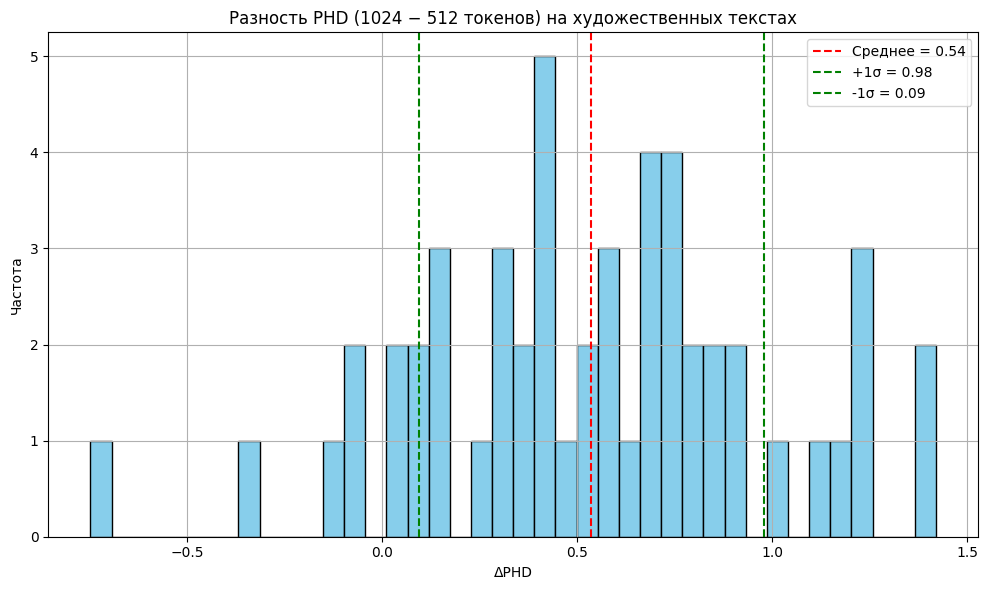

In [ ]:
mu = np.mean(phd_diff_list)
std = np.std(phd_diff_list)

plt.figure(figsize=(10, 6))
plt.hist(phd_diff_list, bins=40, color='skyblue', edgecolor='black')
plt.axvline(mu, color='red', linestyle='--', label=f"Среднее = {mu:.2f}")
plt.axvline(mu + std, color='green', linestyle='--', label=f"+1σ = {mu + std:.2f}")
plt.axvline(mu - std, color='green', linestyle='--', label=f"-1σ = {mu - std:.2f}")
plt.title("Разность PHD (1024 − 512 токенов) на художественных текстах")
plt.xlabel("ΔPHD")
plt.ylabel("Частота")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Наблюдаем смещение вправо, что говорит о более сложном пространстве у более длинных текстов. То есть теория подтвердилась.

## Изменение ID внутри одного жанра

Теперь посмотрим как будет себя вести `ID`, если объединить два разных текста одного жанра. Для этого посмотрим `ID` полных текстов и объединенных двух половинок этих текстов, чтобы они были одной длины с исходными.

In [8]:
MAX_TOKENS = 1024
HALF_TOKENS = MAX_TOKENS // 2
N_TRIES = 8
NUM_PAIRS = 30

model_path = 'Qwen/Qwen1.5-1.8B'
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
def get_trimmed_text(text, num_tokens=MAX_TOKENS):
    inputs = tokenizer(text, truncation=True, max_length=num_tokens, return_tensors="pt")
    return tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)

In [ ]:
phd_a_list = []
phd_b_list = []
phd_mixed_list = []
phd_mixed_gt_both_list = []

for i in tqdm(range(80)):
    try:
        text_a = bookcorpus[i * 2]['text'][9000:]  # Обрезаем интро
        text_b = bookcorpus[i * 2 + 1]['text'][9000:]

        # Получение первых 1024 токенов
        text_a_trim = get_trimmed_text(text_a, MAX_TOKENS)
        text_b_trim = get_trimmed_text(text_b, MAX_TOKENS)

        # Считается PHD на каждом полном тексте
        phd_a = get_phd_single_loop(text_a_trim, solver, n_tries=N_TRIES, max_length=MAX_TOKENS)
        phd_b = get_phd_single_loop(text_b_trim, solver, n_tries=N_TRIES, max_length=MAX_TOKENS)

        # Разбивается по 512 токенов
        tokens_a = tokenizer(text_a_trim, return_tensors="pt")['input_ids'][0][:HALF_TOKENS]
        tokens_b = tokenizer(text_b_trim, return_tensors="pt")['input_ids'][0][:HALF_TOKENS]
        mixed_tokens = torch.cat([tokens_a, tokens_b], dim=0).unsqueeze(0)

        # Декодируется обратно
        mixed_text = tokenizer.decode(mixed_tokens[0], skip_special_tokens=True)

        # PHD на смешанном
        phd_mixed = get_phd_single_loop(mixed_text, solver, n_tries=N_TRIES, max_length=MAX_TOKENS)

        # Сравнение
        is_mixed_greater = int(phd_mixed > max(phd_a, phd_b))

        phd_a_list.append(phd_a)
        phd_b_list.append(phd_b)
        phd_mixed_list.append(phd_mixed)
        phd_mixed_gt_both_list.append(is_mixed_greater)

    except Exception as e:
        print(f"Ошибка на паре #{i}: {e}")
        continue

  0%|          | 0/80 [00:00<?, ?it/s]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

  1%|▏         | 1/80 [06:48<8:57:14, 408.03s/it]

mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1002 point_jump = 137
input_shape: (1002, 2048)
mn_points = 40 max_points = 1002 point_jump = 137
input_shape: (1002, 2048)
mn_points = 40 max_points = 1002 point_jump = 137
input_shape: (1002, 2048)
mn_points = 

  2%|▎         | 2/80 [13:17<8:36:20, 397.18s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

  4%|▍         | 3/80 [19:58<8:31:48, 398.81s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

  5%|▌         | 4/80 [26:41<8:27:16, 400.48s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

  6%|▋         | 5/80 [33:31<8:25:03, 404.04s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 

  8%|▊         | 6/80 [39:30<7:59:16, 388.60s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

  9%|▉         | 7/80 [46:05<7:55:32, 390.85s/it]

mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 

 10%|█         | 8/80 [51:45<7:29:24, 374.50s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

 11%|█▏        | 9/80 [58:22<7:31:27, 381.51s/it]

mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 999 point_jump = 137
input_shape: (999, 2048)
mn_points = 40 max_points = 999 point_jump = 137
input_shape: (999, 2048)
mn_points = 40 max_points = 999 point_jump = 137
input_shape: (999, 2048)
mn_points = 40 max_points = 

 12%|█▎        | 10/80 [1:04:03<7:10:36, 369.10s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 14%|█▍        | 11/80 [1:10:30<7:10:53, 374.69s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

 15%|█▌        | 12/80 [1:16:57<7:08:39, 378.22s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 16%|█▋        | 13/80 [1:23:27<7:06:28, 381.92s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 18%|█▊        | 14/80 [1:29:58<7:03:03, 384.59s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 19%|█▉        | 15/80 [1:36:25<6:57:23, 385.28s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 20%|██        | 16/80 [1:42:52<6:51:37, 385.90s/it]

mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 21%|██▏       | 17/80 [1:48:57<6:38:40, 379.69s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 22%|██▎       | 18/80 [1:55:37<6:38:29, 385.63s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 24%|██▍       | 19/80 [2:02:12<6:34:53, 388.41s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 25%|██▌       | 20/80 [2:08:47<6:30:33, 390.55s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 

 26%|██▋       | 21/80 [2:15:14<6:22:50, 389.32s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 28%|██▊       | 22/80 [2:21:44<6:16:44, 389.73s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 

 29%|██▉       | 23/80 [2:28:15<6:10:23, 389.88s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 30%|███       | 24/80 [2:34:56<6:07:00, 393.23s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 31%|███▏      | 25/80 [2:41:29<6:00:31, 393.30s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 32%|███▎      | 26/80 [2:48:02<5:53:45, 393.07s/it]

mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 34%|███▍      | 27/80 [2:54:33<5:46:49, 392.63s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 35%|███▌      | 28/80 [3:00:58<5:38:15, 390.29s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 

 36%|███▋      | 29/80 [3:06:51<5:22:08, 378.99s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 38%|███▊      | 30/80 [3:13:18<5:17:53, 381.47s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 39%|███▉      | 31/80 [3:19:50<5:14:09, 384.69s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 

 40%|████      | 32/80 [3:25:43<5:00:00, 375.01s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 41%|████▏     | 33/80 [3:32:11<4:56:56, 379.06s/it]

mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 

 42%|████▎     | 34/80 [3:38:41<4:52:59, 382.16s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 44%|████▍     | 35/80 [3:45:14<4:49:12, 385.61s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 45%|████▌     | 36/80 [3:51:53<4:45:39, 389.54s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 46%|████▋     | 37/80 [3:58:27<4:40:06, 390.85s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 48%|████▊     | 38/80 [4:05:02<4:34:26, 392.07s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 49%|████▉     | 39/80 [4:11:37<4:28:33, 393.02s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

 50%|█████     | 40/80 [4:18:12<4:22:27, 393.68s/it]

mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1006 point_jump = 138
input_shape: (1006, 2048)
mn_points = 40 max_points = 1006 point_jump = 138
input_shape: (1006, 2048)
mn_points = 40 max_points = 1006 point_jump = 138
input_shape: (1006, 2048)
mn_points = 40 max_points = 1006 point_jump = 138
input_shape: (1006, 2048)
mn_points = 40 max_points = 1006 point_jump = 138
input_shape: (1006, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 

 51%|█████▏    | 41/80 [4:24:03<4:07:32, 380.82s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 988 point_jump = 135
input_shape: (988, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 40 max_poi

 52%|█████▎    | 42/80 [4:30:24<4:01:07, 380.72s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 54%|█████▍    | 43/80 [4:36:56<3:56:58, 384.28s/it]

mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 55%|█████▌    | 44/80 [4:43:33<3:52:45, 387.93s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1013 point_jump = 139
input_shape: (1013, 2048)
mn_points = 40 max_points = 1013 point_jump = 139
input_shape: (1013, 2048)
mn_points = 40 max_points = 1013 point_jump = 139
input_shape: (1013, 2048)
mn_points = 40 max_points = 1013 point_jump = 139
input_shape: (1013, 2048)
mn_points = 40 max_points = 1013 point_jump = 139
input_shape: (1013, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 

 56%|█████▋    | 45/80 [4:49:38<3:42:23, 381.24s/it]

mn_points = 40 max_points = 978 point_jump = 134
input_shape: (978, 2048)
mn_points = 40 max_points = 978 point_jump = 134
input_shape: (978, 2048)
mn_points = 40 max_points = 978 point_jump = 134
input_shape: (978, 2048)
mn_points = 40 max_points = 978 point_jump = 134
input_shape: (978, 2048)
mn_points = 40 max_points = 978 point_jump = 134
input_shape: (978, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 

 57%|█████▊    | 46/80 [4:55:30<3:30:59, 372.35s/it]

mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 59%|█████▉    | 47/80 [5:02:02<3:28:08, 378.43s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 

 60%|██████    | 48/80 [5:08:28<3:23:02, 380.71s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 61%|██████▏   | 49/80 [5:14:54<3:17:25, 382.10s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 62%|██████▎   | 50/80 [5:21:23<3:12:03, 384.11s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 64%|██████▍   | 51/80 [5:27:50<3:06:11, 385.22s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 

 65%|██████▌   | 52/80 [5:33:41<2:54:51, 374.70s/it]

mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

 66%|██████▋   | 53/80 [5:39:58<2:49:02, 375.66s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 68%|██████▊   | 54/80 [5:46:25<2:44:09, 378.84s/it]

mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 

 69%|██████▉   | 55/80 [5:52:45<2:38:01, 379.26s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 70%|███████   | 56/80 [5:59:08<2:32:07, 380.33s/it]

mn_points = 40 max_points = 972 point_jump = 133
input_shape: (972, 2048)
mn_points = 40 max_points = 972 point_jump = 133
input_shape: (972, 2048)
mn_points = 40 max_points = 972 point_jump = 133
input_shape: (972, 2048)
mn_points = 40 max_points = 972 point_jump = 133
input_shape: (972, 2048)
mn_points = 40 max_points = 972 point_jump = 133
input_shape: (972, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 973 point_jump = 133
input_shape: (973, 2048)
mn_points = 40 max_points = 973 point_jump = 133
input_shape: (973, 2048)
mn_points = 40 max_points = 973 point_jump = 133
input_shape: (973, 2048)
mn_points = 40 max_points = 

 71%|███████▏  | 57/80 [6:05:06<2:23:16, 373.75s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 

 72%|███████▎  | 58/80 [6:11:28<2:17:54, 376.09s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 74%|███████▍  | 59/80 [6:17:58<2:13:05, 380.28s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 75%|███████▌  | 60/80 [6:24:24<2:07:22, 382.11s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 76%|███████▋  | 61/80 [6:30:49<2:01:17, 383.03s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 78%|███████▊  | 62/80 [6:37:17<1:55:21, 384.54s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 79%|███████▉  | 63/80 [6:43:51<1:49:44, 387.35s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 80%|████████  | 64/80 [6:50:21<1:43:27, 387.97s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 81%|████████▏ | 65/80 [6:56:53<1:37:18, 389.25s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 82%|████████▎ | 66/80 [7:03:22<1:30:46, 389.06s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

 84%|████████▍ | 67/80 [7:09:43<1:23:47, 386.71s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1018 point_jump = 139
input_shape: (1018, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 85%|████████▌ | 68/80 [7:16:08<1:17:15, 386.33s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 86%|████████▋ | 69/80 [7:22:40<1:11:07, 387.93s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 88%|████████▊ | 70/80 [7:29:18<1:05:11, 391.12s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 89%|████████▉ | 71/80 [7:35:50<58:42, 391.34s/it]  

mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 90%|█████████ | 72/80 [7:41:48<50:50, 381.27s/it]

mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1004 point_jump = 137
input_shape: (1004, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 40 max_points = 1012 point_jump = 138
input_shape: (1012, 2048)
mn_points = 

 91%|█████████▏| 73/80 [7:48:18<44:47, 384.00s/it]

mn_points = 40 max_points = 948 point_jump = 129
input_shape: (948, 2048)
mn_points = 40 max_points = 948 point_jump = 129
input_shape: (948, 2048)
mn_points = 40 max_points = 948 point_jump = 129
input_shape: (948, 2048)
mn_points = 40 max_points = 948 point_jump = 129
input_shape: (948, 2048)
mn_points = 40 max_points = 948 point_jump = 129
input_shape: (948, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 955 point_jump = 130
input_shape: (955, 2048)
mn_points = 40 max_points = 955 point_jump = 130
input_shape: (955, 2048)
mn_points = 40 max_points = 955 point_jump = 130
input_shape: (955, 2048)
mn_points = 40 max_points = 

 92%|█████████▎| 74/80 [7:54:18<37:40, 376.67s/it]

mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 996 point_jump = 136
input_shape: (996, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_points = 1007 point_jump = 138
input_shape: (1007, 2048)
mn_points = 40 max_poi

 94%|█████████▍| 75/80 [8:00:43<31:36, 379.26s/it]

mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 

 95%|█████████▌| 76/80 [8:07:07<25:21, 380.50s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 96%|█████████▋| 77/80 [8:13:32<19:06, 382.01s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 1000 point_jump = 137
input_shape: (1000, 2048)
mn_points = 40 max_points = 1000 point_jump = 137
input_shape: (1000, 2048)
mn_points = 40 max_points = 1000 point_jump = 137
input_shape: (1000, 2048)
mn_points = 40 max_poi

 98%|█████████▊| 78/80 [8:19:44<12:37, 378.93s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 99%|█████████▉| 79/80 [8:26:12<06:21, 381.75s/it]

mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

100%|██████████| 80/80 [8:32:09<00:00, 384.12s/it]


In [ ]:
df_mix_compare = pd.DataFrame({
    "PHD_A": phd_a_list,
    "PHD_B": phd_b_list,
    "PHD_mixed": phd_mixed_list,
    "PHD_mixed_gt_both": phd_mixed_gt_both_list
})


df_mix_compare.to_csv("phd_mixed_comparison.csv", index=False)

# Подсчитаем долю случаев, когда PHD(mixed) > max(PHD_A, PHD_B)
percentage = 100 * np.mean(phd_mixed_gt_both_list)
print(f"Доля случаев, когда PHD(смешанный) > max(PHD_A, PHD_B): {percentage:.2f}%")

Доля случаев, когда PHD(смешанный) > max(PHD_A, PHD_B): 11.25%


## Объединение художетсвенного с научным

In [17]:
phd_a_list = []
phd_b_list = []
phd_mixed_list = []
phd_mixed_gt_both_list = []

for i in tqdm(range(NUM_PAIRS)):
    try:
        # Художественный
        text_a = bookcorpus[i]['text'][9000:]
        # Научный
        text_b = arxiv[i]['article'][500:]

        text_a_trim = get_trimmed_text(text_a, MAX_TOKENS)
        text_b_trim = get_trimmed_text(text_b, MAX_TOKENS)

        phd_a = get_phd_single_loop(text_a_trim, solver, n_tries=N_TRIES, max_length=MAX_TOKENS)
        phd_b = get_phd_single_loop(text_b_trim, solver, n_tries=N_TRIES, max_length=MAX_TOKENS)

        tokens_a = tokenizer(text_a_trim, return_tensors="pt")['input_ids'][0][:HALF_TOKENS]
        tokens_b = tokenizer(text_b_trim, return_tensors="pt")['input_ids'][0][:HALF_TOKENS]
        mixed_tokens = torch.cat([tokens_a, tokens_b], dim=0).unsqueeze(0)

        mixed_text = tokenizer.decode(mixed_tokens[0], skip_special_tokens=True)

        phd_mixed = get_phd_single_loop(mixed_text, solver, n_tries=N_TRIES, max_length=MAX_TOKENS)

        is_mixed_greater = int(phd_mixed > max(phd_a, phd_b))

        phd_a_list.append(phd_a)
        phd_b_list.append(phd_b)
        phd_mixed_list.append(phd_mixed)
        phd_mixed_gt_both_list.append(is_mixed_greater)

    except Exception as e:
        print(f"Ошибка на паре #{i}: {e}")
        continue

  0%|          | 0/30 [00:00<?, ?it/s]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

  3%|▎         | 1/30 [10:01<4:50:38, 601.33s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 40 max_points = 1010 point_jump = 138
input_shape: (1010, 2048)
mn_points = 

  7%|▋         | 2/30 [19:54<4:38:26, 596.65s/it]

mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1003 point_jump = 137
input_shape: (1003, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 10%|█         | 3/30 [29:35<4:25:08, 589.22s/it]

mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1009 point_jump = 138
input_shape: (1009, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 13%|█▎        | 4/30 [39:18<4:14:20, 586.95s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 17%|█▋        | 5/30 [49:06<4:04:45, 587.42s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 

 20%|██        | 6/30 [58:55<3:55:11, 587.97s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 971 point_jump = 133
input_shape: (971, 2048)
mn_points = 40 max_points = 971 point_jump = 133
input_shape: (971, 2048)
mn_points = 40 max_points = 971 point_jump = 133
input_shape: (971, 2048)
mn_points = 40 max_points = 971 point_jump = 133
input_shape: (971, 2048)
mn_points = 40 max_points = 971 point_jump = 133
input_shape: (971, 2048)
mn_points = 40 max_poi

 23%|██▎       | 7/30 [1:07:35<3:36:50, 565.69s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 27%|██▋       | 8/30 [1:17:30<3:30:50, 575.04s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 40 max_points = 1016 point_jump = 139
input_shape: (1016, 2048)
mn_points = 

 30%|███       | 9/30 [1:26:29<3:17:17, 563.71s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_points = 991 point_jump = 135
input_shape: (991, 2048)
mn_points = 40 max_poi

 33%|███▎      | 10/30 [1:36:10<3:09:38, 568.94s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 37%|███▋      | 11/30 [1:46:06<3:02:50, 577.41s/it]

mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 

 40%|████      | 12/30 [1:55:06<2:49:48, 566.03s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 

 43%|████▎     | 13/30 [2:05:01<2:42:50, 574.73s/it]

mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 47%|████▋     | 14/30 [2:14:53<2:34:39, 579.94s/it]

mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 40 max_points = 1015 point_jump = 139
input_shape: (1015, 2048)
mn_points = 

 50%|█████     | 15/30 [2:23:48<2:21:36, 566.46s/it]

mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 958 point_jump = 131
input_shape: (958, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 

 53%|█████▎    | 16/30 [2:33:03<2:11:22, 563.06s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 57%|█████▋    | 17/30 [2:42:59<2:04:05, 572.75s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 

 60%|██████    | 18/30 [2:51:57<1:52:27, 562.26s/it]

mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 979 point_jump = 134
input_shape: (979, 2048)
mn_points = 40 max_points = 874 point_jump = 119
input_shape: (874, 2048)
mn_points = 40 max_points = 874 point_jump = 119
input_shape: (874, 2048)
mn_points = 40 max_points = 874 point_jump = 119
input_shape: (874, 2048)
mn_points = 40 max_points = 874 point_jump = 119
input_shape: (874, 2048)
mn_points = 40 max_points = 874 point_jump = 119
input_shape: (874, 2048)
mn_points = 40 max_points = 874 point_

 63%|██████▎   | 19/30 [2:59:45<1:37:54, 534.05s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 67%|██████▋   | 20/30 [3:09:33<1:31:42, 550.28s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 70%|███████   | 21/30 [3:19:22<1:24:17, 561.93s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 40 max_points = 1017 point_jump = 139
input_shape: (1017, 2048)
mn_points = 

 73%|███████▎  | 22/30 [3:29:08<1:15:53, 569.13s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 40 max_points = 1019 point_jump = 139
input_shape: (1019, 2048)
mn_points = 

 77%|███████▋  | 23/30 [3:38:50<1:06:50, 572.99s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

 80%|████████  | 24/30 [3:48:42<57:52, 578.67s/it]  

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 40 max_points = 1014 point_jump = 139
input_shape: (1014, 2048)
mn_points = 

 83%|████████▎ | 25/30 [3:58:28<48:24, 580.88s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 40 max_points = 1021 point_jump = 140
input_shape: (1021, 2048)
mn_points = 

 87%|████████▋ | 26/30 [4:08:26<39:04, 586.05s/it]

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 90%|█████████ | 27/30 [4:18:20<29:24, 588.32s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 40 max_points = 1020 point_jump = 140
input_shape: (1020, 2048)
mn_points = 

 93%|█████████▎| 28/30 [4:27:16<19:05, 572.61s/it]

mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 

 97%|█████████▋| 29/30 [4:37:16<09:40, 580.99s/it]

mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1022 point_jump = 140
input_shape: (1022, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 40 max_points = 1023 point_jump = 140
input_shape: (1023, 2048)
mn_points = 

100%|██████████| 30/30 [4:47:27<00:00, 574.93s/it]


In [18]:
df_cross_mix_with_arxv = pd.DataFrame({
    "PHD_fiction": phd_a_list,
    "PHD_science": phd_b_list,
    "PHD_mixed": phd_mixed_list,
    "PHD_mixed_gt_both": phd_mixed_gt_both_list
})

output_path = "/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week/phd_fiction_science_mixed.csv"
df_cross_mix_with_arxv.to_csv(output_path, index=False)

percentage = 100 * np.mean(phd_mixed_gt_both_list)
print(f"Доля случаев, когда PHD(смешанный) > max(PHD_fiction, PHD_science): {percentage:.2f}%")

Доля случаев, когда PHD(смешанный) > max(PHD_fiction, PHD_science): 0.00%


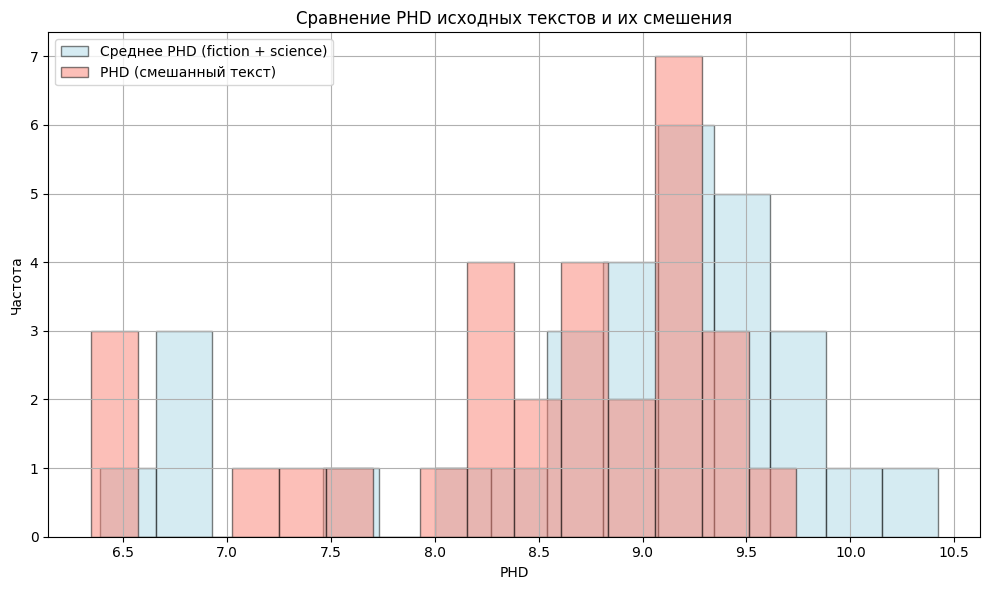

In [15]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week/phd_fiction_science_mixed.csv')

# Вычисляем среднее PHD для исходных текстов
phd_mean_orig = ((df['PHD_fiction'] + df['PHD_science']) / 2).values
phd_mixed = df['PHD_mixed'].values

plt.figure(figsize=(10, 6))
plt.hist(phd_mean_orig, bins=15, alpha=0.5, label='Среднее PHD (fiction + science)', color='lightblue', edgecolor='black')
plt.hist(phd_mixed, bins=15, alpha=0.5, label='PHD (смешанный текст)', color='salmon', edgecolor='black')

plt.title('Сравнение PHD исходных текстов и их смешения')
plt.xlabel('PHD')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

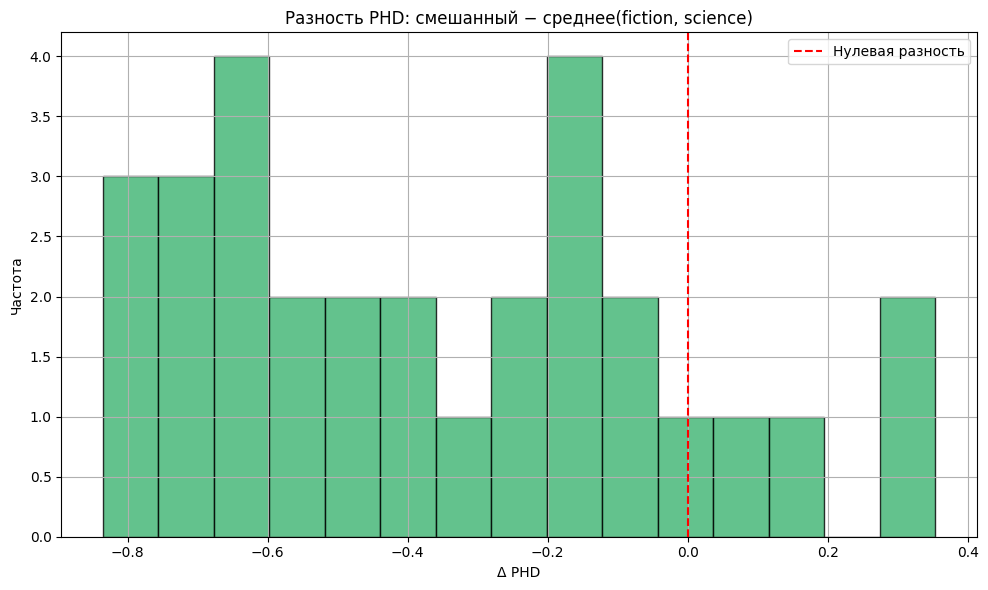

In [16]:
phd_mean_orig = (df['PHD_fiction'] + df['PHD_science']) / 2
phd_diff = df['PHD_mixed'] - phd_mean_orig

plt.figure(figsize=(10, 6))
plt.hist(phd_diff, bins=15, color='mediumseagreen', edgecolor='black', alpha=0.8)
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Нулевая разность')

plt.title('Разность PHD: смешанный − среднее(fiction, science)')
plt.xlabel('Δ PHD')
plt.ylabel('Частота')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Это говорит о том, что смешанный текст имеет меньшую внутреннюю размерность, чем среднее от этих двух текстов. Однако это может быть связано с тем, что мы брали половинки от исходных. Соответсвенно мы теряли в разнообразии слов.

**PS:** стоит попробовать взять целые тексты в качестве объединения.

## Подсчет эмбеддингов по отдельности

В прошлый раз мы брали половины исходных текстов, объединяли и считали эьбеддинги. Интересно посмотреть, что будет, если сначала по отдельности посчитать эмбеддинги, и только потом их объединить.

Для ускорения работы, будем испольщовать уже посчитанные PHD на исходных текстах из `df`.

In [19]:
phd_mixed_embed = []

for i in tqdm(range(NUM_PAIRS), desc="Computing PHD_mixed_embed"):
    try:
        text_fiction = get_trimmed_text(bookcorpus[i]['text'][9000:], MAX_TOKENS)
        text_science = get_trimmed_text(arxiv[i]['article'][500:], MAX_TOKENS)

        # Получаем эмбеддинги по HALF_TOKENS токенов (каждого)
        embeds_fic = get_embeds(text_fiction, max_length=HALF_TOKENS)
        embeds_sci = get_embeds(text_science, max_length=HALF_TOKENS)

        mixed_embed = np.concatenate([embeds_fic, embeds_sci], axis=0)

        phd_val = get_raw_phd(mixed_embed)
        phd_mixed_embed.append(phd_val)

    except Exception as e:
        print(f"Ошибка на паре #{i}: {e}")
        phd_mixed_embed.append(np.nan)

Computing PHD_mixed_embed:   0%|          | 0/30 [00:00<?, ?it/s]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:   3%|▎         | 1/30 [00:25<12:30, 25.87s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:   7%|▋         | 2/30 [00:50<11:45, 25.21s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  10%|█         | 3/30 [01:15<11:20, 25.19s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  13%|█▎        | 4/30 [01:40<10:53, 25.14s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  17%|█▋        | 5/30 [02:04<10:13, 24.55s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  20%|██        | 6/30 [02:29<09:50, 24.59s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  23%|██▎       | 7/30 [02:54<09:30, 24.79s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  27%|██▋       | 8/30 [03:19<09:07, 24.90s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  30%|███       | 9/30 [03:43<08:38, 24.68s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  33%|███▎      | 10/30 [04:08<08:16, 24.83s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  37%|███▋      | 11/30 [04:34<07:56, 25.09s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  40%|████      | 12/30 [05:00<07:34, 25.27s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  43%|████▎     | 13/30 [05:24<07:04, 24.94s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  47%|████▋     | 14/30 [05:49<06:38, 24.89s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  50%|█████     | 15/30 [06:14<06:16, 25.07s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  53%|█████▎    | 16/30 [06:39<05:48, 24.91s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  57%|█████▋    | 17/30 [07:03<05:20, 24.69s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  60%|██████    | 18/30 [07:27<04:55, 24.60s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  63%|██████▎   | 19/30 [07:53<04:34, 24.94s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  67%|██████▋   | 20/30 [08:18<04:10, 25.10s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  70%|███████   | 21/30 [08:43<03:44, 24.99s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  73%|███████▎  | 22/30 [09:07<03:16, 24.55s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  77%|███████▋  | 23/30 [09:32<02:53, 24.78s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  80%|████████  | 24/30 [09:57<02:29, 24.90s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  83%|████████▎ | 25/30 [10:22<02:04, 24.88s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  87%|████████▋ | 26/30 [10:46<01:38, 24.56s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  90%|█████████ | 27/30 [11:11<01:14, 24.80s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  93%|█████████▎| 28/30 [11:36<00:49, 24.93s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed:  97%|█████████▋| 29/30 [12:01<00:24, 24.77s/it]

mn_points =  40 max_points =  1024 point_jump =  140
input_shape: (1024, 2048)


Computing PHD_mixed_embed: 100%|██████████| 30/30 [12:25<00:00, 24.85s/it]


In [20]:
df['PHD_mixed_embed'] = phd_mixed_embed

df.to_csv('/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week/phd_embed_mixed.csv', index=False)

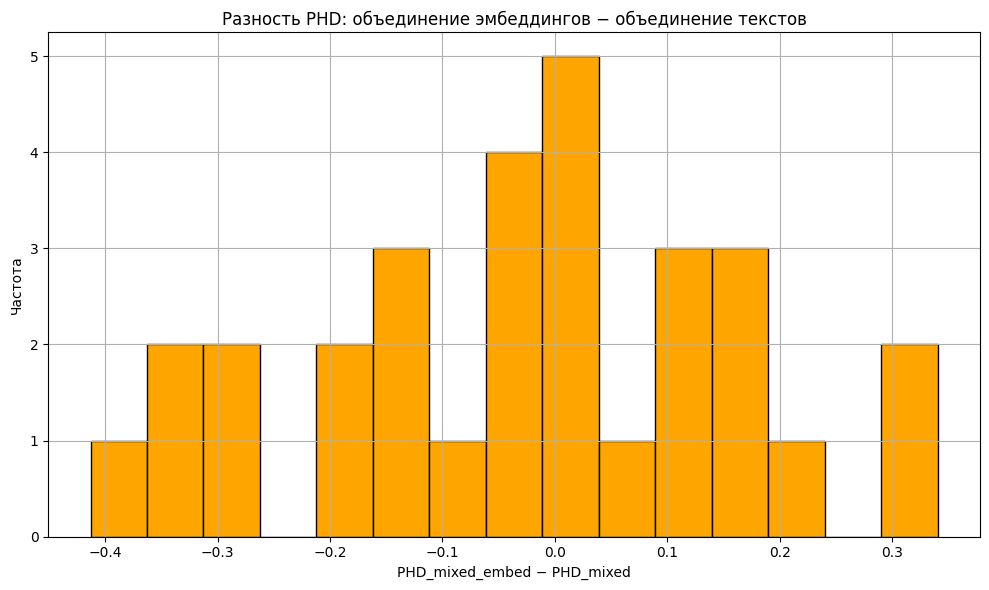

In [23]:
diff = df['PHD_mixed_embed'] - df['PHD_mixed']

plt.figure(figsize=(10, 6))
plt.hist(diff.dropna(), bins=15, color='orange', edgecolor='black')
plt.title("Разность PHD: объединение эмбеддингов − объединение текстов")
plt.xlabel("PHD_mixed_embed − PHD_mixed")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

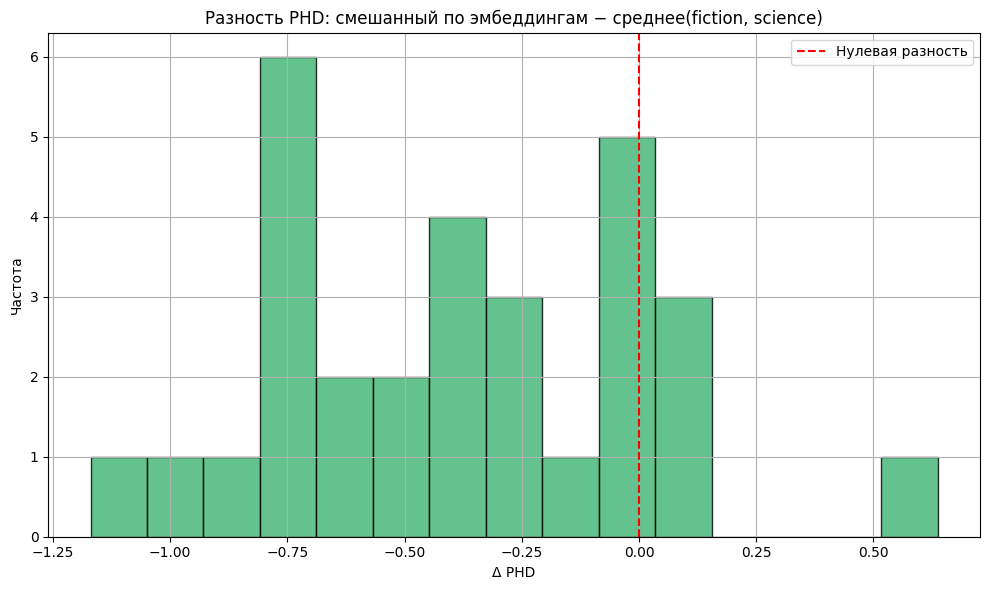

In [24]:
phd_mean_orig = (df['PHD_fiction'] + df['PHD_science']) / 2
phd_diff = df['PHD_mixed_embed'] - phd_mean_orig

plt.figure(figsize=(10, 6))
plt.hist(phd_diff, bins=15, color='mediumseagreen', edgecolor='black', alpha=0.8)
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Нулевая разность')

plt.title('Разность PHD: смешанный по эмбеддингам − среднее(fiction, science)')
plt.xlabel('Δ PHD')
plt.ylabel('Частота')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Смешанный по эмбеддингам получился даже еще меньше, чем просто смешанный текст. Учитывая прошлые ноутбуки, где глобальное усреднение давало более богатое представление текста, чем по каждому тексту по отдельности, то получаем, что модель эмбеддинга увеличивает разнообразие вектора токенов для конкретного текст (пытается найти более глубокую взимосвязь). Это в целом и было ожидаемо. Что тогда будет на более весомых моделях?

PS: Если будет желание получить результаты поточнее, то можно запустить на большем числе текстов.

## Сравнение PHD двух жанров

/tmp/ipython-input-26-1806849868.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True,


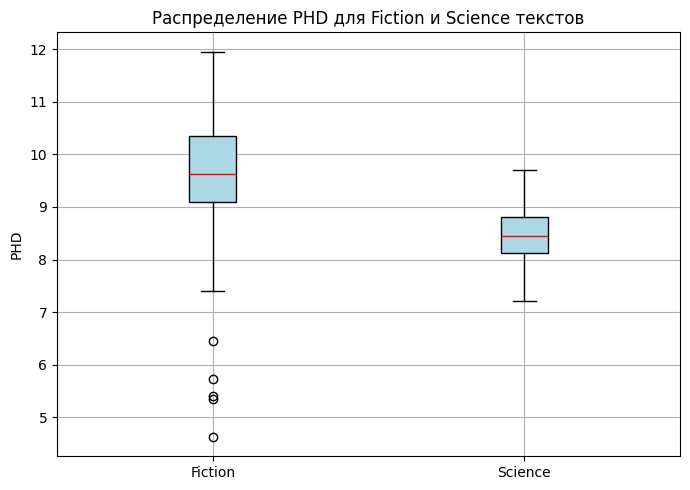

In [26]:
data = [df['PHD_fiction'].dropna(), df['PHD_science'].dropna()]
labels = ['Fiction', 'Science']

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'))
plt.title('Распределение PHD для Fiction и Science текстов')
plt.ylabel('PHD')
plt.grid(True)
plt.tight_layout()
plt.show()